In [192]:
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
import re
import os

In [193]:
df_path = '../../data/whisper-small-runs.csv'
df = pd.read_csv(df_path)
# only looking at first 10 epochs
df = df[(df['epoch'].isna()) | (df['epoch']<11)]
df.head()

C:\Users\marks\AppData\Local\Temp\ipykernel_12556\3805254241.py:2: DtypeWarning: Columns (4,6,9,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(df_path)


,tag,value,experiment_name,step,preds_name,index,date,checkpoint,csv_name,dataset,...,LoRA,lang_prompt,train_lang_token,embedding_distance_regularization_type,distance_regularization_lambda,ewc_lambda,lm_beta,lm_alpha,beam,epoch
0,test_loss,2.131800,whisper-small,0,whisper-small/tira-en+sw-test,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,test_model_preparation_time,0.002400,whisper-small,0,whisper-small/tira-en+sw-test,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,test_wer,0.798058,whisper-small,0,whisper-small/tira-en+sw-test,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,test_mer,0.661401,whisper-small,0,whisper-small/tira-en+sw-test,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,test_wil,0.823157,whisper-small,0,whisper-small/tira-en+sw-test,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [194]:
df.loc[[153,344],'lang_prompt']

153    NaN
344    NaN
Name: lang_prompt, dtype: object

# Metadata

In [195]:
# get more detailed colnames
metrics = ['cer', 'wer']
def get_metric(s):
    for m in metrics:
        if m in s:
            return m
    return ''
df['metric']=df['tag'].apply(get_metric)
# df.loc[df['tag'].str.contains('test'),'metric']=''
df['metric'].value_counts()

metric
       107518
wer      5429
cer      5429
Name: count, dtype: int64

In [196]:
# index Tira test data before changing columns
tira_mono_mask = (df['dataset']=='tira-clean-split')&(~df['preds_name'].isna())

# get eval dataset for each row
unique_datasets = ['fl_en', 'HH20210312', 'HH20210913', 'tira-clean-split', 'sasoc-cs', 'sasoc-zul', 'sasoc-en', 'nchlt_zul', 'nchlt_eng', 'tira_cs']

def get_dataset(s):
    for dataset in unique_datasets:
        if dataset in s:
            return dataset


df['dataset']=df['tag'].apply(get_dataset)
# ignore FLEURS and NCHLT
df.loc[
    df['experiment_name'].str.contains('tira')&df['dataset'].isna(),
    'dataset'
] = 'tira-cs'
df.loc[
    (df['experiment_name'].str.contains('zulu'))&df['dataset'].isna(),
    'dataset'
] = 'sasoc-cs'
df.loc[
    (df['preds_name'].fillna('').str.contains('tira')),
    'dataset'
] = 'tira-cs'
df.loc[
    (df['preds_name'].fillna('').str.contains('zulu')),
    'dataset'
] = 'sasoc-cs'
df['dataset'].value_counts(), df['dataset'].isna().sum()

(dataset
 tira-cs      70994
 sasoc-cs     46278
 fl_en          792
 nchlt_zul      312
 Name: count, dtype: int64,
 0)

In [ ]:
# so we can compare no LID loss to using LID loss
df['lid_loss_alpha']=df['lid_loss_alpha'].fillna(0)
df['ewc_lambda']=df['ewc_lambda'].fillna(0)

In [ ]:
# make column "regularization"
df['ewc']=df['ewc_lambda']>0
df['lid_loss']=df['lid_loss_alpha']>0
df['regularization']='none'
df.loc[df['ewc'], 'regularization']='ewc'
df.loc[df['lid_loss'], 'regularization']='lid_loss'
df.loc[df['ewc'] & df['lid_loss'], 'regularization']='ewc+lid_loss'

In [199]:
# infer train data used from experiment name
df['train_data']='tira'
df.loc[df['experiment_name'].str.contains('tira-eng'), 'train_data']='tira-eng'
df.loc[df['experiment_name'].str.contains('tira-eng-50pct'), 'train_data']='tira-eng-50pct'
df.loc[df['experiment_name'].str.contains('tira-eng-cs'), 'train_data']='misc'
df.loc[df['experiment_name'].str.contains('tira-eng-cs-20-80-small'), 'train_data']='tira-eng-cs-20-80-small'
df.loc[df['experiment_name'].str.contains('tira-eng-cs-20-80-large'), 'train_data']='tira-eng-cs-20-80-large'
df.loc[df['experiment_name'].str.contains('tira-eng-cs-50-50-large'), 'train_data']='tira-eng-cs-50-50'
df.loc[df['experiment_name'].str.contains('tira-eng-cs-clean'), 'train_data']='tira-eng-cs-clean'
df.loc[df['experiment_name'].str.contains('tira-eng-cs-long'), 'train_data']='tira-eng-cs-long'
df.loc[df['experiment_name'].str.contains('tira-all'), 'train_data']='tira-all'
df.loc[df['experiment_name'].str.contains('tira-all-clean'), 'train_data']='tira-all-clean'
df.loc[df['experiment_name'].str.contains('tira-all-long'), 'train_data']='tira-all-long'

df.loc[df['experiment_name'].str.contains('zulu'), 'train_data']='zulu'
df.loc[df['experiment_name'].str.contains('zulu-swahili-eng'), 'train_data']='zulu+eng'
df.loc[df['experiment_name'].str.contains('zulu-swahili-eng-50pct'), 'train_data']='zulu+eng-50pct'
df.loc[df['experiment_name'].str.contains('zulu-eng-cs'), 'train_data']='zulu-eng-cs'
df.loc[df['experiment_name'].str.contains('zulu-eng-all'), 'train_data']='zulu-eng-all'

df['train_data'].value_counts()

train_data
tira                 14698
zulu-eng-all         10661
zulu-eng-cs          10409
tira-all-clean       10115
zulu+eng             10111
tira-all-long         9956
tira-eng              9717
tira-eng-cs-long      9572
tira-eng-cs-clean     9540
tira-eng-50pct        8924
zulu+eng-50pct        8780
zulu                  5893
Name: count, dtype: int64

In [200]:
# sequester Tira test data before dropping rows
tira_mono = df[tira_mono_mask].copy()
df=df[~df['dataset'].isin(['fl_en', 'nchlt_zul'])]
df=df[~tira_mono_mask]

# use `processed` metrics for Tira and non-processed for Zulu
print(df.shape)
tira_mask = (df['dataset'].str.contains('tira'))
zulu_mask = (df['dataset'].str.contains('sasoc'))
proc_mask = (df['tag'].str.contains('processed'))
df=df[(proc_mask|~tira_mask)&(~proc_mask|~zulu_mask)]
df['tag']=df['tag'].str.replace('_processed', '')
print(df.shape)
df.loc[df['tag'].str.contains('wer'),'tag'].unique()

C:\Users\marks\AppData\Local\Temp\ipykernel_12556\792468652.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df[~tira_mono_mask]


(117132, 26)
(57531, 26)


array(['test_wer', 'test_tira_wer', 'test_eng_wer', 'test_misc_wer',
       'eval_wer', 'eval_zulu_wer', 'eval_eng_wer', 'eval_misc_wer',
       'test_zulu_wer', 'eval_tira_wer', 'eval/wer',
       'eval/sasoc-cs-en+sw_wer'], dtype=object)

In [201]:
# df=df.sort_values('step')
# for experiment in df['experiment_name'].unique():
#     for tag in df['tag'].unique():
#         if 'loss' not in tag:
#             continue
#         loss_mask = df['tag']==tag
#         experiment_mask = df['experiment_name']==experiment
#         loss_diff = np.diff(df.loc[experiment_mask&loss_mask, 'value'])
#         loss_diff = np.insert(loss_diff, 0, 0)
#         df.loc[experiment_mask&loss_mask, 'loss_diff']=loss_diff
# df.head()


# Tira test

In [202]:
tira_mono.pivot_table(
    index=['train_data', 'epoch','regularization'],
    columns='tag',
    values='value'
)[['test_wer', 'test_cer']]

tag                                      test_wer   test_cer
train_data        epoch regularization                      
tira              2.0   none             0.738448   0.226241
                  5.0   ewc              0.657807   0.175254
                        lid_loss         0.656599   0.175476
                  8.0   ewc+lid_loss     0.659317   0.173607
tira-all-clean    5.0   ewc              0.712172   0.206042
                  7.0   ewc+lid_loss     0.700695   0.200214
                  9.0   lid_loss         0.686802   0.198567
                        none             0.691332   0.197811
tira-eng          5.0   lid_loss         0.695258   0.206887
                  6.0   ewc              0.701903   0.201593
                  8.0   ewc+lid_loss     0.689520   0.202750
                        none             0.678949   0.204351
tira-eng-cs-clean 3.0   ewc              2.533978   1.484205
                        none             2.276050   1.480691
                  9.0   ewc+lid_loss     1.332226   0.665554
                        lid_loss         1.595288   0.821454
tira-eng-cs-long  4.0   ewc             11.461190  11.490746
                  6.0   ewc+lid_loss     1.022652   0.426054
                        lid_loss         1.070976   0.477087
                        none            12.066747  20.492436

# Baseline metrics

In [203]:
baseline_mask = df['experiment_name']=='whisper-small'
df.loc[
    (baseline_mask)&
    df['preds_name'].str.contains('tira'),
    'dataset'
] = 'tira-cs'
df.loc[
    (baseline_mask)&
    df['preds_name'].str.contains('zulu'),
    'dataset'
] = 'sasoc-cs'
df.loc[baseline_mask, 'preds_name']
df.loc[baseline_mask, 'lang_prompt']=df.loc[baseline_mask, 'preds_name'].apply(
    lambda s: re.match(
        r'whisper-small/(?:tira|zulu)-([^-]+)(-test)?',
        s.replace('en-sw', 'en+sw')
    ).groups()[0])
# not sure what happened here but some junk rows got added
df=df[df['lang_prompt']!='lang']
baseline_mask = df['experiment_name']=='whisper-small'
baseline_df=df[baseline_mask]
baseline_df = baseline_df.pivot_table(index=['dataset', 'lang_prompt'], columns='tag', values='value', aggfunc=lambda x:(x[~x.isna()].item()))
baseline_df[['test_wer', 'test_cer',]]

tag                    test_wer   test_cer
dataset  lang_prompt                      
sasoc-cs en            1.819661   1.209520
         en+sw         1.522631   0.970643
         lid          19.515205  13.540253
         sw            6.313119   4.159486
tira-cs  en            0.854571   0.688327
         en+sw         0.702500   0.606189
         lid           8.034959   6.183621
         sw            2.541863   1.949745

In [ ]:
df.loc[baseline_mask, ['dataset', 'lang_prompt']]

,dataset,lang_prompt
95,tira-cs,en+sw
96,tira-cs,en+sw
97,tira-cs,en+sw
98,tira-cs,en+sw
99,tira-cs,en+sw
...,...,...
3048,tira-cs,en
3049,tira-cs,en
3050,tira-cs,en
3051,tira-cs,en


### Set epoch=0 for each experiment to Whisper w/ <|en|> for Tira, Whisper w/ <|en|><|sw|> for Zulu

In [205]:
print(df.shape)
baseline_dfs = []
for exp in df['experiment_name'].unique():
    if exp=='whisper-small':
        continue
    exp_mask=(df['experiment_name']!=exp)
    dataset = 'tira-cs' if 'tira' in exp else 'sasoc-cs'
    lang_prompt = 'en' if 'tira' in exp else 'en+sw'
    baseline = df[
        (df['experiment_name']=='whisper-small')&
        (df['dataset']==dataset)&
        (df['lang_prompt']==lang_prompt)
    ].copy()
    baseline['train_data']='tira_baseline' if 'tira' in exp else 'zulu_baseline'
    baseline['epoch']=0
    baseline['regularization']=df.loc[exp_mask,'regularization'].iloc[0]
    baseline_dfs.append(baseline)
df = df[df['epoch']!=0]
print(df.shape)
df=pd.concat([df]+baseline_dfs)
df.shape

(57531, 26)
(56433, 26)


(65561, 26)

# Line plots

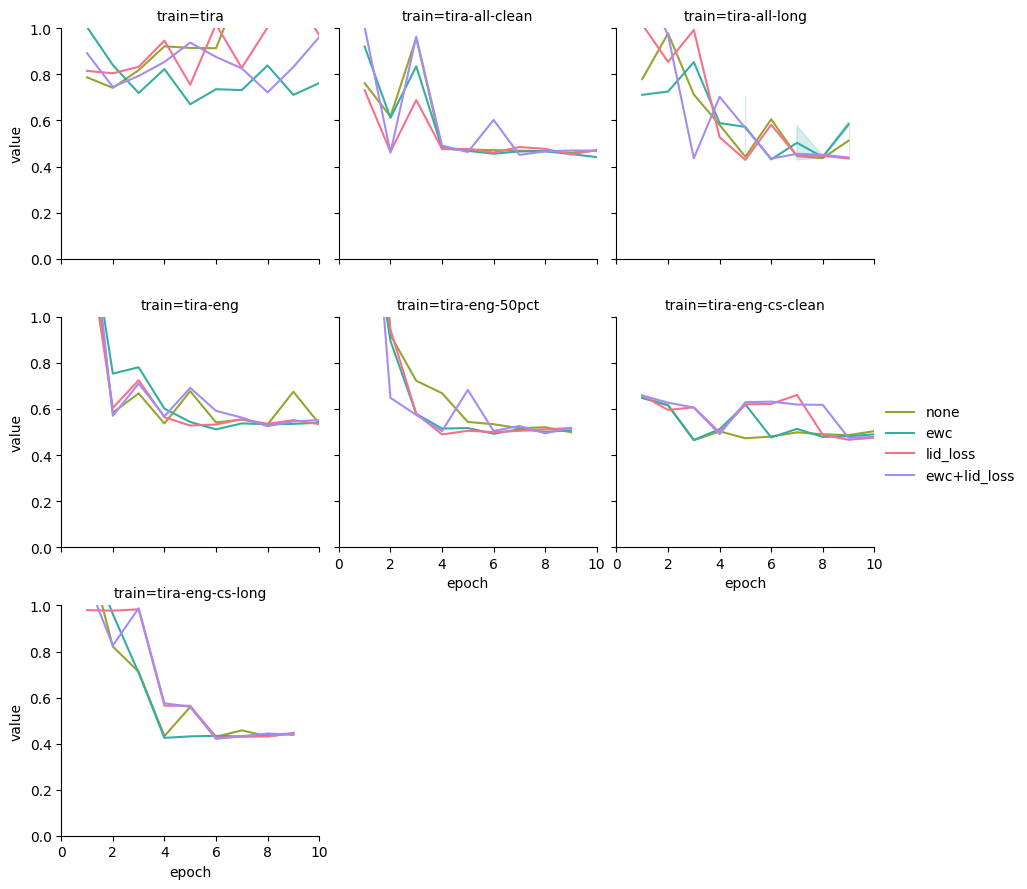

In [ ]:
df['beam']=df['beam'].fillna(0).astype(float)
df['lm_alpha']=df['lm_alpha'].astype(str)
g = sb.FacetGrid(
    df[
        # (df['experiment_name'].str.contains('zulu')) &
        # ~(df['experiment_name'].str.contains('zulu-swahili-eng')) &
        (df['experiment_name'].str.contains('tira')) &
        # (~df['train_data'].str.contains('20-80'))&
        # (~df['train_data'].str.contains('misc'))&
        # (df['train_data'].str.contains('zulu-eng'))&
        # (df['train_data']!='tira-all')&
        # (df['lang_prompt']=='swahili') &
        # (df['lang_prompt']=='croatian')&
        # (df['dataset'].isin(['fl_en', 'tira-clean-split', 'sasoc-cs', 'nchlt_zul'])) &
        (df['dataset'].isin(['sasoc-cs', 'tira-cs'])) &
        (df['ewc_lambda'].isin([0,1])) &
        (df['lid_loss_alpha'].isin([0,0.2])) &
        # (df['beam']==2)&
        (df['beam']==0)&
        # (~df['csv_name'].isna())&
        # (df['pred_name'].isna())&
        # (df['regularization']=='none')&
        # (df['tag'].str.contains('loss'))
        # (df['tag']=='train/loss')
        (df['tag'].isin(['eval_wer']))
        # (df['metric']!='')
        # (df['LoRA'])
    ],
    # col='ewc_lambda',
    col='train_data',
    col_wrap=3,
    # row='lm_alpha',
    # col='lid_loss_alpha',
    # row='beam',
    # row='dataset',
    # sharey=False,
)
palette_map= {
    key: color for key, color in
    zip(['lid_loss', 'none', 'ewc', 'ewc+lid_loss'], sb.color_palette('husl',4))
}
g.map_dataframe(
    sb.lineplot,
    x='epoch',
    # x='step',
    y='value',
    # y='loss_diff',
    # hue='lid_loss_alpha',
    hue='regularization',
    palette=palette_map,
    # hue='ewc_lambda',
    # errorbar=None,
    legend='full',
    # style='tag',
    # style='tag',
)
# g.set_titles('eval={row_name}, train={col_name}')
g.set_titles('train={col_name}')
g.add_legend()
# g.set_title('Performance on English while decoding as Yoruba')
g.set(ylim=(0,1))
g.set(xlim=(0,10))
plt.show()

# Get best checkpoints for each model

In [ ]:
# first need to create a mask to separate lang-specific error rates from general
lang_metrics = []
for metric in ['cer', 'wer']:
    for lang in ['eng', 'tira', 'zulu', 'misc']:
        lang_metrics.append(f"{lang}_{metric}")
has_lang_metric = lambda s: any(m in s for m in lang_metrics)
no_lang_metric_mask = ~df['tag'].apply(has_lang_metric)
df.loc[(df['metric']!='')&no_lang_metric_mask,'tag'].unique()

array(['test_wer', 'test_cer', 'eval_wer', 'eval_cer', 'eval/cer',
       'eval/wer', 'eval/sasoc-cs-en+sw_cer', 'eval/sasoc-cs-en+sw_wer'],
      dtype=object)

In [ ]:
df['best_checkpoint']=False
df.loc[df['train_data'].str.contains('baseline'),'best_checkpoint']=True
epoch_past_0 = df['epoch']>0
with open('best_checkpoint.csv', 'wb') as f:
    for exp in df['experiment_name'].unique():
        if exp == 'whisper-small':
            continue
        exp_mask = df['experiment_name']==exp
        wer_mask = df['metric']=='wer'
        sorted_df = df[exp_mask&epoch_past_0&wer_mask&no_lang_metric_mask].sort_values('value')
        if len(sorted_df)==0:
            continue
        best_epoch = sorted_df.iloc[0]['epoch']
        epoch_mask = df['epoch']==best_epoch
        df.loc[exp_mask&epoch_past_0&epoch_mask,'best_checkpoint']=True

        dataset_path = '/home/mjsimmons/datasets/tira_eval' if 'tira' in exp else\
        '/home/mjsimmons/datasets/sasoc-cs'
        model_path = '/mnt/LocalStorage/mjsimmons/'+exp
        checkpoint = f"checkpoint-{sorted_df.iloc[0]['step']}"
        lang='tira' if 'tira' in exp else 'zulu'
        f.write(bytes(','.join([model_path,checkpoint,dataset_path,lang])+'\n', encoding='utf8'))

df['best_checkpoint'].value_counts()


best_checkpoint
False    46660
True     18901
Name: count, dtype: int64

# Make table showing baseline and final test results: overall & lang specific

In [209]:
reg_map = {
    'ewc': 'EWC',
    'lid_loss': 'LID loss',
    'none': 'Plain finetune',
    'ewc+lid_loss': 'EWC+LID loss',
    'train_data': 'Train dataset',
    'baseline': 'Baseline'
}
reg_list = [
    'baseline',
    'none',
    'ewc',
    'lid_loss',
    'ewc+lid_loss',
    'train_data',
]
ds_map = {
    'tira': 'Mono',
    'tira-all-clean': 'All (short)',
    'tira-all-long': 'All (long)',
    'tira-eng': 'Biling',
    'tira-eng-50pct': 'Biling (50\\%)',
    'tira-eng-cs-clean': "CS (short)",
    'tira-eng-cs-long': "CS (long)",
    'tira baseline': 'Baseline',
    'zulu': "Mono",
    'zulu+eng': "Biling",
    'zulu+eng-50pct': "Biling (50\\%)",
    'zulu-eng-all': 'All',
    'zulu-eng-cs': 'CS',
    'zulu baseline': 'Baseline',
    'tira_baseline': 'Baseline',
    'zulu_baseline': 'Baseline',
}
metric_map = {
    'test_wer': 'WER',
    'test_cer': 'CER',
    'test_eng_hit_rate': 'Eng hit rate',
    'test_tira_hit_rate': 'Tira hit rate',
    'test_tira_char_hit_rate': 'Tira char hit rate',
    'test_zulu_hit_rate': 'Zulu hit rate',
    'test_zulu_char_hit_rate': 'Zulu char hit rate',
    'epoch': 'Epoch',
    'train_data': 'Train data',
    'regularization': 'Regularization',
}

In [210]:
def latexify_table(df, fp):
    df=df.apply(lambda col:col.apply(lambda n: round(n,2)) if pd.api.types.is_float_dtype(col) else col)
    with open(fp, 'w') as f:
        latex_str=df.to_latex(index=True, escape=False, sparsify=True, multirow=False)
        latex_str=latex_str.replace(r'\multicolumn{2}{r}', r'\multicolumn{2}{l}')
        latex_str=latex_str.replace('Zulu','isiZulu')
        f.write(latex_str)

In [ ]:
df['epoch']=df['epoch'].fillna(0).astype(int)

In [ ]:
tira_ds = [
    'Baseline',
    'Mono',
    'Biling',
    'Biling (50\\%)',
    "CS (short)",
    "CS (long)",
    'All (short)',
    'All (long)',
]
split='test'
tira_metrics = []
for metric in ['_wer', '_cer']:
    tira_metrics.append(split+metric)
for metric in ['_hit_rate', '_char_hit_rate', '_insertion_rate']:
    for lang in ['tira', 'eng', 'misc']:
        tira_metrics.append(f"test_{lang}{metric}")

tira_table = df.loc[
    (df['dataset']=='tira-cs')&
    (df['best_checkpoint'])&
    (df['tag'].isin(tira_metrics))
    # (df['tag'].str.contains(split))
].pivot_table(
    columns='tag', index=['train_data', 'regularization', 'epoch'], values='value'
).rename(
    ds_map
).reset_index()
tira_table.columns.name=None
tira_noreg=tira_table.loc[
    (tira_table['regularization']=='none'),
    ['train_data', 'epoch', split+'_wer', split+'_cer', split+'_eng_hit_rate', split+'_tira_hit_rate', split+'_tira_char_hit_rate']
].rename(
    metric_map, axis=1
)
ds_idx = tira_noreg['Train data'].apply(lambda x:tira_ds.index(x))
tira_noreg.index=ds_idx
tira_noreg.index.name=None
tira_noreg=tira_noreg.sort_index()
tira_noreg

,Train data,Epoch,WER,CER,Eng hit rate,Tira hit rate,Tira char hit rate
0,Baseline,0,0.854571,0.688327,0.640642,0.130784,0.225127
1,Mono,2,1.178815,0.808773,0.289079,0.154148,0.350547
2,Biling,8,0.572103,0.506859,0.599628,0.126694,0.157685
3,Biling (50\%),9,0.543961,0.471990,0.656628,0.137797,0.165752
4,CS (short),3,1.116763,0.848262,0.710665,0.197796,0.455175
5,CS (long),6,0.634679,0.484979,0.684900,0.215536,0.443662
6,All (short),9,0.497291,0.363248,0.739938,0.232035,0.431223
7,All (long),9,0.527530,0.383531,0.720403,0.241778,0.479835


In [213]:
latexify_table(tira_noreg, 'tira_noreg.tex')

In [214]:
tira_table.loc[
    tira_table['train_data']=='Baseline',
    'regularization'
] = 'baseline'
tira_mono=tira_table.loc[
    (tira_table['train_data'].isin(['Mono', 'Baseline'])),
    ['regularization', 'epoch', split+'_wer', split+'_cer', split+'_eng_hit_rate', split+'_tira_hit_rate', split+'_tira_char_hit_rate']
].rename(
    metric_map, axis=1
)
reg_idx = tira_mono['Regularization'].map({x:i for i,x in enumerate(reg_list)})
tira_mono.index=reg_idx
tira_mono.index.name=None
tira_mono['Regularization']=tira_mono['Regularization'].map(reg_map)
tira_mono=tira_mono.sort_index()
tira_mono

,Regularization,Epoch,WER,CER,Eng hit rate,Tira hit rate,Tira char hit rate
0,Baseline,0,0.854571,0.688327,0.640642,0.130784,0.225127
1,Plain finetune,2,1.178815,0.808773,0.289079,0.154148,0.350547
2,EWC,5,0.789547,0.651929,0.331390,0.179765,0.404958
3,LID loss,5,0.805454,0.653319,0.300524,0.170955,0.437645
4,EWC+LID loss,8,0.811571,0.662731,0.340518,0.183432,0.399711


In [215]:
latexify_table(tira_mono, 'tira_mono.tex')

In [ ]:
zulu_ds=[
    'Baseline',
    "Mono",
    "Biling",
    "Biling (50\\%)",
    'CS',
    'All',
]
zulu_metrics = []
split = 'test'
for metric in ['_wer', '_cer']:
    zulu_metrics.append(split+metric)
for metric in ['_hit_rate', '_char_hit_rate']:
    for lang in ['zulu', 'eng']:
        zulu_metrics.append(f"{split}_{lang}{metric}")

zulu_table = df.loc[
    (df['dataset']=='sasoc-cs')&
    (df['best_checkpoint'])&
    (df['tag'].isin(zulu_metrics))
    # (df['tag'].str.contains('test'))
].pivot_table(
    columns='tag', index=['train_data', 'regularization', 'epoch'], values='value'
).rename(
    ds_map
).reset_index()
zulu_table.columns.name=None
zulu_noreg=zulu_table.loc[
    (zulu_table['regularization']=='none'),
    ['train_data', 'epoch', split+'_wer', split+'_cer', split+'_eng_hit_rate', split+'_zulu_hit_rate', split+'_zulu_char_hit_rate']
].rename(
    metric_map, axis=1
)
ds_idx = zulu_noreg['Train data'].apply(lambda x:zulu_ds.index(x))
zulu_noreg.index=ds_idx
zulu_noreg.index.name=None
zulu_noreg=zulu_noreg.sort_index()
zulu_noreg

,Train data,Epoch,WER,CER,Eng hit rate,Zulu hit rate,Zulu char hit rate
0,Baseline,0,1.522631,0.970643,0.252082,0.049528,0.275385
1,Mono,4,0.999116,0.527818,0.182106,0.303221,0.724752
2,Biling,9,0.832567,0.427897,0.353469,0.305533,0.692426
3,Biling (50\%),8,1.027228,0.512596,0.364636,0.252265,0.612417
4,CS,8,0.572843,0.263924,0.588949,0.386315,0.763624
5,All,4,0.645332,0.300496,0.587799,0.419779,0.787309


In [217]:
latexify_table(zulu_noreg, 'zulu_noreg.tex')

In [218]:
zulu_table.loc[
    zulu_table['train_data']=='Baseline',
    'regularization'
] = 'baseline'
zulu_mono=zulu_table.loc[
    (zulu_table['train_data'].isin(['Mono', 'Baseline'])),
    ['regularization', 'epoch', split+'_wer', split+'_cer', split+'_eng_hit_rate', split+'_zulu_hit_rate', split+'_zulu_char_hit_rate']
].rename(
    metric_map, axis=1
)
reg_idx = zulu_mono['Regularization'].map({x:i for i,x in enumerate(reg_list)})
zulu_mono.index=reg_idx
zulu_mono.index.name=None
zulu_mono['Regularization']=zulu_mono['Regularization'].map(reg_map)
zulu_mono=zulu_mono.sort_index()
zulu_mono

,Regularization,Epoch,WER,CER,Eng hit rate,Zulu hit rate,Zulu char hit rate
0,Baseline,0,1.522631,0.970643,0.252082,0.049528,0.275385
1,Plain finetune,4,0.999116,0.527818,0.182106,0.303221,0.724752
2,EWC,10,0.959512,0.469074,0.203192,0.303387,0.712393
3,LID loss,5,0.953678,0.482975,0.182485,0.293070,0.717448
4,EWC+LID loss,5,0.903996,0.449834,0.200687,0.293381,0.713111


In [219]:
latexify_table(zulu_mono, 'zulu_mono.tex')

In [246]:
metric_cols = df[
    (df['metric']!='')&
    (df['epoch']<=10) &
    ((df['tag']).str.contains('test')) &
    (df['dataset'].isin(['sasoc-cs', 'tira-cs'])) &
    # ((df['dataset'].str.contains('tira')&~df['csv_name'].isna())|(df['dataset'].str.contains('sasoc')&df['csv_name'].isna()))&
    (df['best_checkpoint']) &
    no_lang_metric_mask
].pivot_table(
    columns=['regularization'],
    values=['value'],
    index=['train_data', 'epoch', 'metric'],
    aggfunc=lambda x:((x.iloc[0])),
).pivot_table(
    index=['train_data','epoch'],
    columns=['metric'],
).droplevel(
    axis=1,
    level=0
)
metric_cols

regularization                ewc           ewc+lid_loss            lid_loss  \
metric                        cer       wer          cer       wer       cer   
train_data        epoch                                                        
tira              2           NaN       NaN          NaN       NaN       NaN   
                  5      0.651929  0.789547          NaN       NaN  0.653319   
                  8           NaN       NaN     0.662731  0.811571       NaN   
tira-all-clean    7           NaN       NaN     0.358698  0.491697       NaN   
                  9           NaN       NaN          NaN       NaN  0.365506   
                  10     0.350259  0.494669          NaN       NaN       NaN   
tira-all-long     5           NaN       NaN          NaN       NaN  0.429479   
                  6           NaN       NaN     0.342028  0.453417       NaN   
                  7      0.348453  0.463031          NaN       NaN       NaN   
                  9           NaN       NaN          NaN       NaN       NaN   
tira-eng          5           NaN       NaN          NaN       NaN  0.489807   
                  6      0.532421  0.643943          NaN       NaN       NaN   
                  8           NaN       NaN     0.490814  0.568607       NaN   
tira-eng-50pct    4           NaN       NaN          NaN       NaN  0.570347   
                  6      0.513458  0.607761          NaN       NaN       NaN   
                  8           NaN       NaN     0.535477  0.623667       NaN   
                  9           NaN       NaN          NaN       NaN       NaN   
tira-eng-cs-clean 3      0.790852  1.050865          NaN       NaN       NaN   
                  9           NaN       NaN     0.419373  0.591680  0.622026   
tira-eng-cs-long  4      0.543847  0.693935          NaN       NaN       NaN   
                  6           NaN       NaN     0.395409  0.494144  0.391171   
tira_baseline     0           NaN       NaN          NaN       NaN       NaN   
zulu              4           NaN       NaN          NaN       NaN       NaN   
                  5           NaN       NaN     0.449834  0.903996  0.482975   
                  10     0.469074  0.959512          NaN       NaN       NaN   
zulu+eng          6      0.360765  0.706506          NaN       NaN       NaN   
                  9           NaN       NaN     0.329267  0.688119       NaN   
                  10          NaN       NaN          NaN       NaN  0.391237   
zulu+eng-50pct    5           NaN       NaN     0.552541  1.070191       NaN   
                  7      0.411092  0.800566          NaN       NaN       NaN   
                  8           NaN       NaN          NaN       NaN  0.451125   
zulu-eng-all      4           NaN       NaN     0.273221  0.615099       NaN   
                  8      0.219873  0.509371          NaN       NaN       NaN   
                  10          NaN       NaN          NaN       NaN  0.253336   
zulu-eng-cs       8           NaN       NaN          NaN       NaN       NaN   
                  9      0.244655  0.553748     0.263337  0.563119  0.242573   
zulu_baseline     0           NaN       NaN          NaN       NaN       NaN   

regularization                         none            
metric                        wer       cer       wer  
train_data        epoch                                
tira              2           NaN  0.808773  1.178815  
                  5      0.805454       NaN       NaN  
                  8           NaN       NaN       NaN  
tira-all-clean    7           NaN       NaN       NaN  
                  9      0.498689  0.363248  0.497291  
                  10          NaN       NaN       NaN  
tira-all-long     5      0.536095       NaN       NaN  
                  6           NaN       NaN       NaN  
                  7           NaN       NaN       NaN  
                  9           NaN  0.383531  0.527530  
tira-eng          5      0.564761       NaN       NaN  
               

In [247]:
reg_names = ['none', 'ewc', 'lid_loss', 'ewc+lid_loss']
reg_dfs = []
for reg in reg_names:
    reg_df=metric_cols[reg]
    reg_df=reg_df.sort_values('wer')
    reg_df=reg_df.reset_index()
    reg_df=reg_df.rename_axis('', axis=1)
    # reg_df=reg_df[reg_df['epoch']>0]
    reg_df=reg_df.drop_duplicates(subset=['train_data'], keep='first')
    reg_df['regularization']=reg
    reg_dfs.append(reg_df)
reg_dfs = pd.concat(reg_dfs)
table=reg_dfs.melt(
    value_vars=['cer', 'wer', 'epoch'],
    var_name='var',
    id_vars=['train_data', 'regularization']
).sort_values(
    'train_data'
).pivot_table(
    columns=['regularization', 'var'],
    index='train_data'
)
table.columns.names=[None,'regularization',None]
table=table.droplevel(0,axis=1)
table=table.reset_index()
is_tira=table['train_data'].str.contains('tira')
table = pd.concat({'Tira': table[is_tira], 'Zulu': table[~is_tira]})

table=table.rename(reg_map, axis=1)

table['Train dataset']=table['Train dataset'].map(ds_map)

for column in table.columns:
    if column[1]=='epoch':
        table[column]=table[column].astype(int)
    elif column[1]=='':
        pass
    elif column[1] in ('wer', 'cer'):
        table[column]=table[column].apply(lambda n:f"{n:.2f}")
for language in ['Tira', 'Zulu']:
    is_language = table.index.get_level_values(0)==language
    for column in table.columns:
        if column[1] in ('wer', 'cer'):
            min_idx = table.loc[language,column].astype(float).idxmin()
            min_val = table.at[(language,min_idx),column]
            table.loc[(is_language)&(table[column]==min_val),column]=r'\textbf{'+min_val+r'}'
split_bf = lambda s:s.removeprefix(r'\textbf{').removesuffix(r'}')
def italicize_min_per_row(row):
    if row['Train dataset'].item() == 'Baseline':
        return row
    cer = row.index.get_level_values(1)=='cer'
    min_cer_idx = row[cer].apply(split_bf).astype(float).idxmin()
    min_cer_value=row[min_cer_idx]
    row[cer&(row==min_cer_value)]=r'\textit{'+min_cer_value+r'}'

    wer = row.index.get_level_values(1)=='wer'
    min_wer_idx = row[wer].apply(split_bf).astype(float).idxmin()
    min_wer_value=row[min_wer_idx]
    row[wer&(row==min_wer_value)]=r'\textit{'+min_wer_value+r'}'
    return row
table=table.apply(italicize_min_per_row, axis=1)
table=table.loc[:,table.columns.get_level_values(1)!='epoch']
table=pd.concat({
    'Tira':table.loc['Tira'].set_index('Train dataset'),
    'Zulu':table.loc['Zulu'].set_index('Train dataset'),
})
table.columns.names=None,None
ordered_cols = []
for reg in ['Plain finetune', 'EWC', 'LID loss', 'EWC+LID loss']:
    for metric in ['wer', 'cer']:
        ordered_cols.append((reg,metric))
table=table[ordered_cols]
ordered_rows = []
# for ds in ['Baseline', 'Mono', 'Biling', 'Biling (50\%)', 'CS (short)', 'CS (long)', 'All (short)', 'All (long)']:
for ds in ['Mono', 'Biling', 'CS (short)', 'CS (long)', 'All (short)']:
    ordered_rows.append(('Tira', ds))
# for ds in ['Baseline', 'Mono', 'Biling', 'Biling (50\%)', 'CS', 'All']:
for ds in ['Mono', 'Biling', 'Biling (50\%)', 'CS', 'All']:
    ordered_rows.append(('Zulu', ds))
table=table.loc[ordered_rows]
table

Plain finetune                                    EWC  \
                              wer            cer                     wer   
     Train dataset                                                         
Tira Mono                    1.18           0.81           \textit{0.79}   
     Biling                  0.57           0.51                    0.64   
     CS (short)              1.12           0.85                    1.05   
     CS (long)               0.63           0.48                    0.69   
     All (short)    \textbf{0.50}  \textbf{0.36}           \textit{0.49}   
Zulu Mono                    1.00           0.53                    0.96   
     Biling                  0.83           0.43                    0.71   
     Biling (50\%)           1.03           0.51           \textit{0.80}   
     CS             \textbf{0.57}  \textbf{0.26}           \textit{0.55}   
     All                     0.65           0.30  \textit{\textbf{0.51}}   

                                                 LID loss                 \
                                       cer            wer            cer   
     Train dataset                                                         
Tira Mono                    \textit{0.65}           0.81  \textit{0.65}   
     Biling                           0.53  \textit{0.56}  \textit{0.49}   
     CS (short)                       0.79           0.84           0.62   
     CS (long)                        0.54  \textbf{0.50}  \textit{0.39}   
     All (short)    \textit{\textbf{0.35}}  \textbf{0.50}  \textbf{0.37}   
Zulu Mono                             0.47           0.95           0.48   
     Biling                           0.36           0.81           0.39   
     Biling (50\%)           \textit{0.41}           0.89           0.45   
     CS                      \textit{0.24}  \textbf{0.55}  \textbf{0.24}   
     All            \textit{\textbf{0.22}}  \textbf{0.55}           0.25   

                     EWC+LID loss                 
                              wer            cer  
     Train dataset                                
Tira Mono                    0.81           0.66  
     Biling                  0.57  \textit{0.49}  
     CS (short)     \textit{0.59}  \textit{0.42}  
     CS (long)      \textit{0.49}           0.40  
     All (short)    \textit{0.49}           0.36  
Zulu Mono           \textit{0.90}  \textit{0.45}  
     Biling         \textit{0.69}  \textit{0.33}  
     Biling (50\%)           1.07           0.55  
     CS             \textbf{0.56}  \textbf{0.26}  
     All                     0.62           0.27

In [248]:
table['Plain finetune'].reset_index(level=1).rename({'wer': 'WER', 'cer': 'CER'}, axis=1)

,Train dataset,WER,CER
Tira,Mono,1.18,0.81
Tira,Biling,0.57,0.51
Tira,CS (short),1.12,0.85
Tira,CS (long),0.63,0.48
Tira,All (short),\textbf{0.50},\textbf{0.36}
Zulu,Mono,1.00,0.53
Zulu,Biling,0.83,0.43
Zulu,Biling (50\%),1.03,0.51
Zulu,CS,\textbf{0.57},\textbf{0.26}
Zulu,All,0.65,0.30


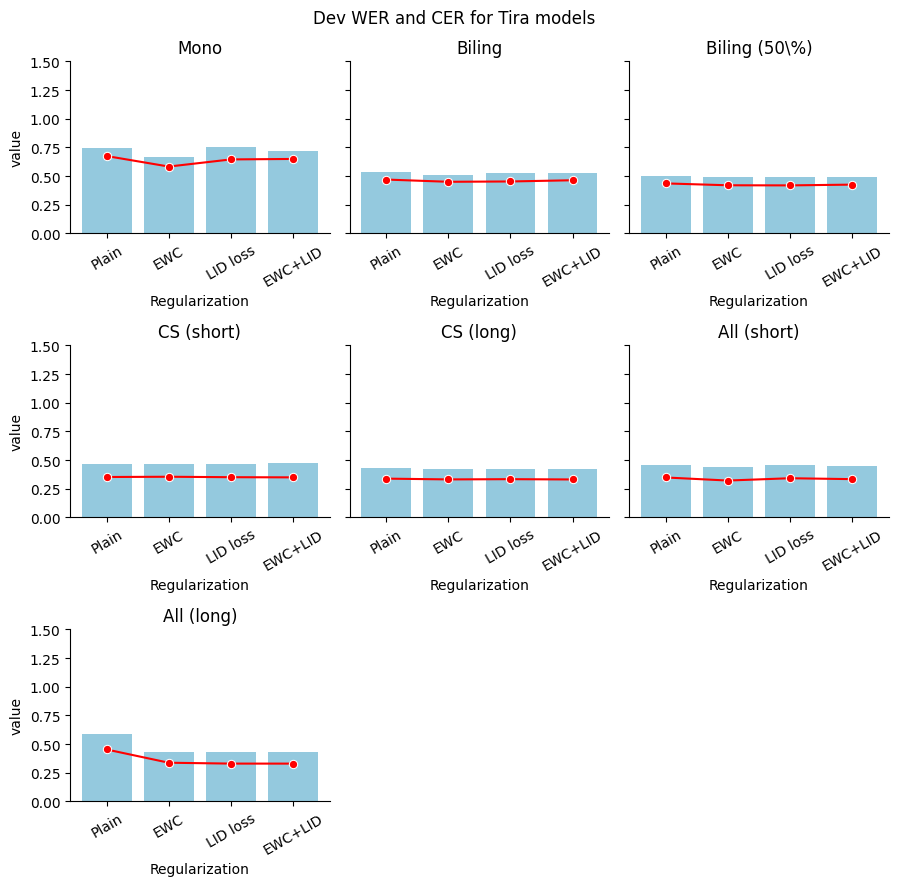

In [293]:
tira_plot_df = df[
    (df['best_checkpoint'])&
    no_lang_metric_mask&
    (df['tag'].str.contains('eval'))&
    (df['preds_name'].isna())&
    (df['experiment_name'].str.contains('tira'))&
    (~df['train_data'].str.contains('baseline'))
].copy(deep=True)
tira_all_long_dups = (
    (tira_plot_df['regularization'].isin(['none', 'ewc']))&
    (tira_plot_df['train_data']=='tira-all-long')&
    (tira_plot_df['step']!=25182)&
    (tira_plot_df['step']!=19580)
)
tira_plot_df = tira_plot_df[~tira_all_long_dups]
tira_plot_df['Train dataset']=tira_plot_df['train_data'].map(ds_map)
ds_idcs = tira_plot_df['Train dataset'].apply(lambda x: tira_ds.index(x))

reg_map_short = {
    'ewc': 'EWC',
    'lid_loss': 'LID loss',
    'none': 'Plain',
    'ewc+lid_loss': 'EWC+LID',
}
reg_list_short = ['Plain', 'EWC', 'LID loss', 'EWC+LID']
tira_plot_df['Regularization']=tira_plot_df['regularization'].map(reg_map_short)
reg_idcs = tira_plot_df['Regularization'].apply(lambda x:reg_list_short.index(x))
tira_plot_df.index=ds_idcs
tira_plot_df=tira_plot_df.set_index(reg_idcs, append=True)
tira_plot_df=tira_plot_df.sort_index()
    
g=sb.FacetGrid(
    tira_plot_df,
    col='Train dataset',
    col_wrap=3,
    sharex=False,
)
g.set_titles("{col_name}")
# Map bar plot and line plot onto each facet
for ax in g.axes.flat:
    dataset = ax.get_title()
    subdf = tira_plot_df[tira_plot_df['Train dataset'] == dataset]
    wer_df = subdf[subdf['metric']=='wer']
    cer_df = subdf[subdf['metric']=='cer']
    sb.barplot(x='Regularization', y='value', data=wer_df, ax=ax, color='skyblue')
    sb.lineplot(x='Regularization', y='value', data=cer_df, ax=ax, color='red', marker='o')
    ax.set_title(f'{dataset}')
    ax.tick_params(axis='x', rotation=30)

g.figure.suptitle('Dev WER and CER for Tira models')
g.set(ylim=(0,1.5))
plt.tight_layout()
plt.show()

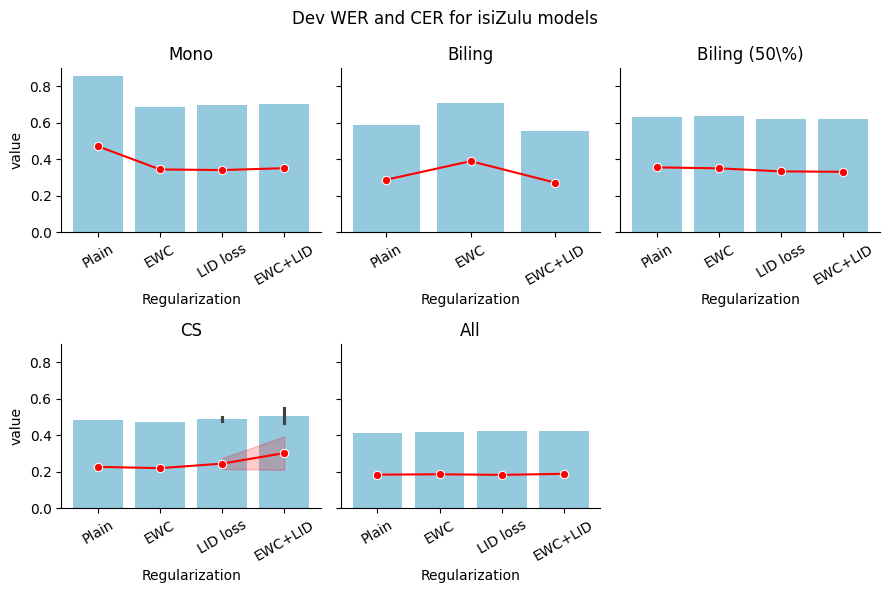

In [320]:
zulu_plot_df = df[
    (df['best_checkpoint'])&
    no_lang_metric_mask&
    (df['tag'].str.contains('eval'))&
    (df['csv_name'].isna())&
    (df['experiment_name'].str.contains('zulu'))&
    (~df['train_data'].str.contains('baseline'))
].copy(deep=True)
zulu_plot_df['Train dataset']=zulu_plot_df['train_data'].map(ds_map)
ds_idcs = zulu_plot_df['Train dataset'].apply(lambda x: zulu_ds.index(x))

zulu_plot_df['Regularization']=zulu_plot_df['regularization'].map(reg_map_short)
reg_idcs = zulu_plot_df['Regularization'].apply(lambda x:reg_list_short.index(x))
zulu_plot_df.index=ds_idcs
zulu_plot_df=zulu_plot_df.set_index(reg_idcs, append=True)
zulu_plot_df=zulu_plot_df.sort_index()
zulu_dup_mask = (
    (zulu_plot_df['Regularization'].isin(['EWC+LID', 'LID loss']))&
    (zulu_plot_df['Train dataset'].isin(['CS', 'Biling']))&
    ((zulu_plot_df['step']==6980)|(zulu_plot_df['step']==6990)|(zulu_plot_df['step']==3490))
)
zulu_plot_df=zulu_plot_df[~zulu_dup_mask]


g=sb.FacetGrid(
    zulu_plot_df,
    col='Train dataset',
    col_wrap=3,
    sharex=False,
)
g.set_titles("{col_name}")
# Map bar plot and line plot onto each facet
for ax in g.axes.flat:
    dataset = ax.get_title()
    subdf = zulu_plot_df[zulu_plot_df['Train dataset'] == dataset]
    wer_df = subdf[subdf['metric']=='wer']
    cer_df = subdf[subdf['metric']=='cer']
    sb.barplot(x='Regularization', y='value', data=wer_df, ax=ax, color='skyblue')
    sb.lineplot(x='Regularization', y='value', data=cer_df, ax=ax, color='red', marker='o')
    ax.set_title(f'{dataset}')
    ax.tick_params(axis='x', rotation=30)

g.figure.suptitle('Dev WER and CER for isiZulu models')
plt.tight_layout()
plt.show()

In [319]:
zulu_plot_df.loc[
    (zulu_plot_df['Regularization'].isin(['EWC+LID', 'LID loss']))&
    (zulu_plot_df['metric'].isin(['wer']))&
    # ((zulu_plot_df['step']==6990)|(zulu_plot_df['step']==3490))&
    (zulu_plot_df['Train dataset'].isin(['CS', 'Biling']))

]


tag     value  \
Train dataset Regularization                                      
2             3               eval/sasoc-cs-en+sw_wer  0.554917   
              3               eval/sasoc-cs-en+sw_wer  0.558748   
4             2                              eval/wer  0.477650   
              2               eval/sasoc-cs-en+sw_wer  0.498084   
              3                              eval/wer  0.464879   
              3               eval/sasoc-cs-en+sw_wer  0.551724   

                                                                experiment_name  \
Train dataset Regularization                                                      
2             3               whisper-small-zulu-swahili-eng-lid-alpha-0.2-e...   
              3               whisper-small-zulu-swahili-eng-lid-alpha-0.2-e...   
4             2                         whisper-small-zulu-eng-cs-lid-alpha-0.2   
              2                         whisper-small-zulu-eng-cs-lid-alpha-0.2   
              3               whisper-small-zulu-eng-cs-lid-alpha-0.2-ewc-la...   
              3               whisper-small-zulu-eng-cs-lid-alpha-0.2-ewc-la...   

                              step preds_name  index                 date  \
Train dataset Regularization                                                
2             3               6291        NaN   64.0  1900-02-11 23:46:04   
              3               6980        NaN   65.0  1900-02-11 23:46:04   
4             2               3150        NaN   64.0  1900-02-12 07:47:45   
              2               3150        NaN  536.0  1900-02-06 04:30:35   
              3               3150        NaN   64.0  1900-02-12 11:47:04   
              3               3150        NaN  536.0  1900-02-05 08:47:39   

                             checkpoint csv_name   dataset  ...  epoch metric  \
Train dataset Regularization                                ...                 
2             3                     NaN      NaN  sasoc-cs  ...      9    wer   
              3                     NaN      NaN  sasoc-cs  ...      9    wer   
4             2                     NaN      NaN  sasoc-cs  ...      9    wer   
              2                     NaN      NaN  sasoc-cs  ...      9    wer   
              3                     NaN      NaN  sasoc-cs  ...      9    wer   
              3                     NaN      NaN  sasoc-cs  ...      9    wer   

                                ewc lid_loss  regularization   train_data  \
Train dataset Regularization                                                
2             3                True     True    ewc+lid_loss     zulu+eng   
              3                True     True    ewc+lid_loss     zulu+eng   
4             2               False     True        lid_loss  zulu-eng-cs   
              2               False     True        lid_loss  zulu-eng-cs   
              3                True     True    ewc+lid_loss  zulu-eng-cs   
              3                True     True    ewc+lid_loss  zulu-eng-cs   

                              best_checkpoint  train_data_group Train dataset  \
Train dataset Regularization                                                    
2             3                          True                bi        Biling   
              3                          True                bi        Biling   
4             2                          True                cs            CS   
              2                          True                cs            CS   
              3                          True                cs            CS   
              3                          True                cs            CS   

                              Regularization  
Train dataset Regularization                  
2             3                      EWC+LID  
              3                      EWC+LID  
4             2                     LID loss  
              2                     LID loss  
              3                   